In [ ]:
!pip install torch torchvision numpy tqdm opencv-python pycocotools



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!nvidia-smi

Mon Mar 24 14:24:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [ ]:
# Paths (Update this with your correct paths)
labels_path = "/content/drive/MyDrive/dataset/train/labels"
image_path = "/content/drive/MyDrive/dataset/train/images"

print("Paths Set!")

Paths Set!


In [ ]:
import os
import json
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

#  Custom Dataset Class
class FasterRCNNDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform if transform else transforms.ToTensor()

        # Load COCO JSON annotations
        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)

        # Mapping from image_id to file_name
        self.image_id_to_filename = {img["id"]: img["file_name"] for img in coco_data["images"]}

        # Group annotations by image_id
        self.image_annotations = {img_id: [] for img_id in self.image_id_to_filename.keys()}
        for ann in coco_data["annotations"]:
            x, y, w, h = ann['bbox']
            category_id = ann['category_id']

            #  Remove invalid bounding boxes (width or height <= 0)
            if w <= 0 or h <= 0:
                print(f"⚠️ Skipping invalid bbox in {self.image_id_to_filename[ann['image_id']]}")
                continue

            #  Remove invalid class IDs (must be >=1)
            if category_id < 1:
                print(f"⚠️ Skipping annotation with invalid class ID {category_id} in {self.image_id_to_filename[ann['image_id']]}")
                continue

            self.image_annotations[ann["image_id"]].append(ann)

        # Store valid image IDs (only those with valid annotations)
        self.image_ids = [img_id for img_id in self.image_id_to_filename.keys() if len(self.image_annotations[img_id]) > 0]

        print(f" Loaded {len(self.image_ids)} valid images with annotations!")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        file_name = self.image_id_to_filename[img_id]
        img_path = os.path.join(self.image_dir, file_name)

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # Load annotations
        boxes, labels = [], []
        for ann in self.image_annotations[img_id]:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
            labels.append(ann['category_id'])   # Class label

        # Convert to PyTorch tensors
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32) if boxes else torch.empty((0, 4), dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64) if labels else torch.empty((0,), dtype=torch.int64),
            "image_id": torch.tensor([img_id], dtype=torch.int64)
        }

        return image, target

#  Collate function for Faster R-CNN
def collate_fn(batch):
    return tuple(zip(*batch))

#  Function to load dataset
def load_faster_rcnn_dataset(image_dir, annotation_file, batch_size=4, shuffle=True, num_workers=2):
    transform = transforms.Compose([transforms.ToTensor()])  # Define transformations

    dataset = FasterRCNNDataset(image_dir, annotation_file, transform=transform)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=collate_fn
    )

    print(f"🚀 DataLoader Loaded with {len(dataset)} valid images!")
    return dataloader

#  Define paths for Train, Validation, and Test
train_path = "/content/drive/MyDrive/dataset/train/images"
train_label = "/content/drive/MyDrive/dataset/train/annotations.json"

val_path = "/content/drive/MyDrive/dataset/val/images"
val_label = "/content/drive/MyDrive/dataset/val/annotations.json"

test_path = "/content/drive/MyDrive/dataset/test/images"
test_label = "/content/drive/MyDrive/dataset/test/annotations.json"

#  Load DataLoaders
train_dataloader = load_faster_rcnn_dataset(train_path, train_label, batch_size=4)
val_dataloader = load_faster_rcnn_dataset(val_path, val_label, batch_size=4, shuffle=False)  # No shuffling for validation
test_dataloader = load_faster_rcnn_dataset(test_path, test_label, batch_size=4, shuffle=False)  # No shuffling for test

#  Check first batch (Train, Validation, Test)
print("\n🔍 Checking First Batch from Train Set...")
train_images, train_targets = next(iter(train_dataloader))
print(f"🖼️ Train Image Shape: {train_images[0].shape}")
print(f"📌 Train Sample Target: {train_targets[0]}")

print("\n🔍 Checking First Batch from Validation Set...")
val_images, val_targets = next(iter(val_dataloader))
print(f"🖼️ Validation Image Shape: {val_images[0].shape}")
print(f"📌 Validation Sample Target: {val_targets[0]}")

print("\n🔍 Checking First Batch from Test Set...")
test_images, test_targets = next(iter(test_dataloader))
print(f"🖼️ Test Image Shape: {test_images[0].shape}")
print(f"📌 Test Sample Target: {test_targets[0]}")

print("\n🎯 Dataset is ready for training! 🚀")


✅ Loaded 2994 valid images with annotations!
🚀 DataLoader Loaded with 2994 valid images!
✅ Loaded 373 valid images with annotations!
🚀 DataLoader Loaded with 373 valid images!
✅ Loaded 377 valid images with annotations!
🚀 DataLoader Loaded with 377 valid images!

🔍 Checking First Batch from Train Set...
🖼️ Train Image Shape: torch.Size([3, 567, 567])
📌 Train Sample Target: {'boxes': tensor([[328.6828, 372.0938, 425.2500, 567.0000]]), 'labels': tensor([2]), 'image_id': tensor([2432])}

🔍 Checking First Batch from Validation Set...
🖼️ Validation Image Shape: torch.Size([3, 655, 655])
📌 Validation Sample Target: {'boxes': tensor([[337.9902, 486.1328, 573.8926, 655.0000]]), 'labels': tensor([2]), 'image_id': tensor([6])}

🔍 Checking First Batch from Test Set...
🖼️ Test Image Shape: torch.Size([3, 640, 640])
📌 Test Sample Target: {'boxes': tensor([[172.2500, 208.5000, 483.7500, 609.5000]]), 'labels': tensor([1]), 'image_id': tensor([6])}

🎯 Dataset is ready for training! 🚀


In [ ]:
# Check a few samples from training data
for images, targets in train_dataloader:    print(f" Batch Size: {len(images)}")
    print(f" First Image Shape: {images[0].shape}")  # Should be (3, H, W) W)
    print(f" First Target: {targets[0]}")
    break  # Check only the first batch


📌 Batch Size: 4
🖼️ First Image Shape: torch.Size([3, 610, 610])
🎯 First Target: {'boxes': tensor([[179.6641, 451.7812, 343.6016, 610.0000]]), 'labels': tensor([2]), 'image_id': tensor([1759])}


In [ ]:



import torch
import torchvision.models.detection as detection
import torch.optim as optim
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔹 Using device: {device}")

# Load DataLoader (ensure train_dataloader is already defined)
try:
    train_dataloader  # Ensure training dataloader exists
except NameError:
    raise ValueError("🚨 Error: `train_dataloader` is not defined!")

# Initialize Faster R-CNN Model
num_classes = 3  # Modify based on the number of classes in your dataset
model = detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Modify classifier head for the correct number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move model to device (GPU or CPU)
model.to(device)

# Define Optimizer & Learning Rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20
gradient_accumulation_steps = 4  # Gradient accumulation steps (adjust as needed)
print(f"🔹 Training for {num_epochs} epochs...")

# Create folder to save model
save_path = "/content/drive/MyDrive/dataset/models"
os.makedirs(save_path, exist_ok=True)

# Function to sanitize bounding boxes (make sure they are within image bounds)
def sanitize_bboxes(bboxes, image_width, image_height):
    bboxes = bboxes.clone()
    bboxes[..., 0::2] = bboxes[..., 0::2].clamp(min=0, max=image_width)
    bboxes[..., 1::2] = bboxes[..., 1::2].clamp(min=0, max=image_height)
    width = bboxes[..., 2] - bboxes[..., 0]
    height = bboxes[..., 3] - bboxes[..., 1]
    invalid_boxes = (width <= 0) | (height <= 0)
    if invalid_boxes.any():
        print(f"🚨 Invalid bounding boxes found: {bboxes[invalid_boxes].cpu().numpy()}")
    bboxes[invalid_boxes] = torch.tensor([0, 0, 1, 1], dtype=torch.float32, device=bboxes.device)
    return bboxes

# Function to sanitize labels (make sure they are within the correct range)
def sanitize_labels(labels, num_classes):
    labels = labels.clone()
    if labels.max() >= num_classes or labels.min() < 0:
        print(f"🚨 Invalid labels found: {labels.cpu().numpy()}")
        labels = labels.clamp(min=0, max=num_classes-1)
    return labels


# Track Losses
train_losses = []

# Training Loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    optimizer.zero_grad()

    for batch_idx, (images, targets) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        try:
            # Move images & targets to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backward pass with Gradient Accumulation
            loss.backward()
            if (batch_idx + 1) % gradient_accumulation_steps == 0 or (batch_idx + 1) == len(train_dataloader):
                optimizer.step()
                optimizer.zero_grad()

            epoch_loss += loss.item()

        except RuntimeError as e:
            print(f"❌ Error in batch {batch_idx}: {e}")
            optimizer.zero_grad()
            continue

    # Compute average training loss
    avg_train_loss = epoch_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Print epoch summary
    print(f"✅ Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")

    # Save the model every 2 epochs
    if (epoch + 1) % 5 == 0:
        model_save_path = os.path.join(save_path, f"epoch{epoch + 1}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"🔹 Model saved at {model_save_path} after epoch {epoch + 1}")

# Plot the training loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid()
plt.show()


🔹 Using device: cuda
🔹 Training for 20 epochs...


Epoch 1/20: 100%|██████████| 749/749 [09:25<00:00,  1.33it/s]


✅ Epoch 1/20 - Train Loss: 0.2043


Epoch 2/20: 100%|██████████| 749/749 [09:35<00:00,  1.30it/s]


✅ Epoch 2/20 - Train Loss: 0.1426


Epoch 3/20: 100%|██████████| 749/749 [09:36<00:00,  1.30it/s]


✅ Epoch 3/20 - Train Loss: 0.1194


Epoch 4/20: 100%|██████████| 749/749 [09:36<00:00,  1.30it/s]


✅ Epoch 4/20 - Train Loss: 0.1009


Epoch 5/20: 100%|██████████| 749/749 [09:37<00:00,  1.30it/s]


✅ Epoch 5/20 - Train Loss: 0.0878
🔹 Model saved at /content/drive/MyDrive/dataset/models/epoch5.pth after epoch 5


Epoch 6/20: 100%|██████████| 749/749 [09:36<00:00,  1.30it/s]


✅ Epoch 6/20 - Train Loss: 0.0719


Epoch 7/20: 100%|██████████| 749/749 [09:36<00:00,  1.30it/s]


✅ Epoch 7/20 - Train Loss: 0.0619


Epoch 8/20: 100%|██████████| 749/749 [09:35<00:00,  1.30it/s]


✅ Epoch 8/20 - Train Loss: 0.0527


Epoch 9/20: 100%|██████████| 749/749 [09:34<00:00,  1.30it/s]


✅ Epoch 9/20 - Train Loss: 0.0450


Epoch 10/20: 100%|██████████| 749/749 [09:32<00:00,  1.31it/s]


✅ Epoch 10/20 - Train Loss: 0.0409
🔹 Model saved at /content/drive/MyDrive/dataset/models/epoch10.pth after epoch 10


Epoch 11/20: 100%|██████████| 749/749 [09:33<00:00,  1.30it/s]


✅ Epoch 11/20 - Train Loss: 0.0353


Epoch 12/20: 100%|██████████| 749/749 [09:40<00:00,  1.29it/s]


✅ Epoch 12/20 - Train Loss: 0.0339


Epoch 13/20: 100%|██████████| 749/749 [09:39<00:00,  1.29it/s]


✅ Epoch 13/20 - Train Loss: 0.0311


Epoch 14/20: 100%|██████████| 749/749 [09:39<00:00,  1.29it/s]


✅ Epoch 14/20 - Train Loss: 0.0290


Epoch 15/20: 100%|██████████| 749/749 [09:39<00:00,  1.29it/s]


✅ Epoch 15/20 - Train Loss: 0.0273
🔹 Model saved at /content/drive/MyDrive/dataset/models/epoch15.pth after epoch 15


Epoch 16/20:   1%|          | 7/749 [00:06<11:47,  1.05it/s]


KeyboardInterrupt: 

Training Losses: [0.20427366554020882, 0.14260134499803565, 0.11937737434565304, 0.10085580663603838, 0.08777492799272683, 0.07186333670495985, 0.06194862297851746, 0.05267700898114129, 0.044978411342247386, 0.04092496192861145, 0.035340801832603116, 0.03385420388682622, 0.03109534065648217, 0.029003519047603746, 0.027337533191781498]


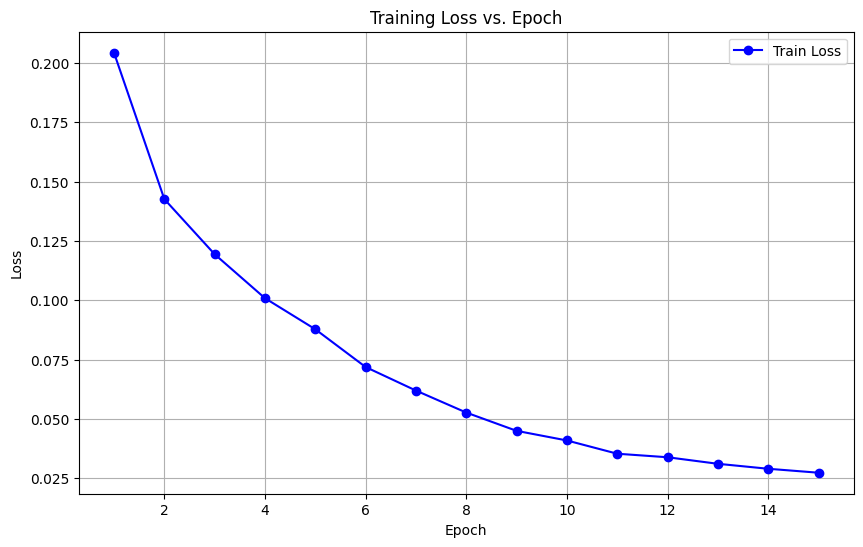

In [ ]:
#training loss curve
# Print train loss values for debugging
print("Training Losses:", train_losses)

# Plot Train Loss vs. Epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker="o", linestyle="-", color="blue")

# Formatting the plot
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


Skipping batch 0 due to mismatch: Predicted=2, True=1
Skipping batch 0 due to mismatch: Predicted=2, True=1
Skipping batch 2 due to mismatch: Predicted=2, True=1
Skipping batch 3 due to mismatch: Predicted=2, True=1
Skipping batch 4 due to mismatch: Predicted=2, True=1
Skipping batch 7 due to mismatch: Predicted=3, True=1
Skipping batch 10 due to mismatch: Predicted=3, True=1
Skipping batch 10 due to mismatch: Predicted=3, True=1
Skipping batch 11 due to mismatch: Predicted=4, True=2
Skipping batch 11 due to mismatch: Predicted=2, True=1
Skipping batch 12 due to mismatch: Predicted=2, True=1
Skipping batch 12 due to mismatch: Predicted=2, True=1
Skipping batch 13 due to mismatch: Predicted=3, True=1
Skipping batch 13 due to mismatch: Predicted=3, True=1
Skipping batch 13 due to mismatch: Predicted=2, True=1
Skipping batch 14 due to mismatch: Predicted=2, True=1
Skipping batch 14 due to mismatch: Predicted=3, True=1
Skipping batch 16 due to mismatch: Predicted=3, True=1
Skipping batch 1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


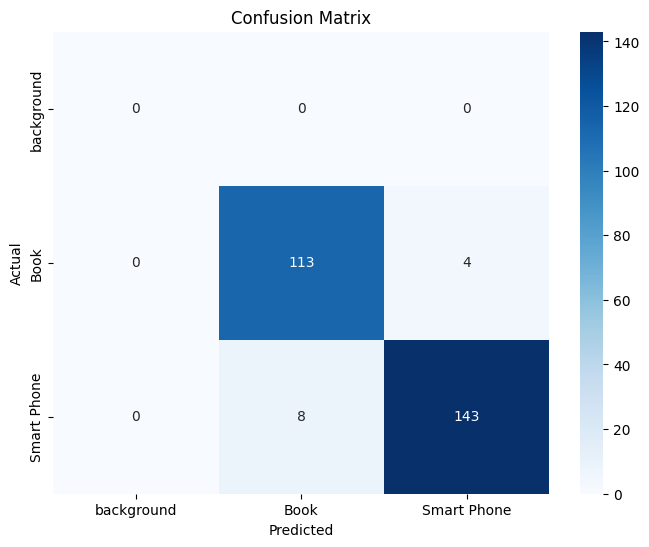


Classification Report:
Accuracy: 95.52%
Class: background
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
Class: Book
  Precision: 0.9339
  Recall: 0.9658
  F1-Score: 0.9496
Class: Smart Phone
  Precision: 0.9728
  Recall: 0.9470
  F1-Score: 0.9597




In [ ]:

# #computing the metrics


import torch
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn

#  Function to compute metrics (precision, recall, F1-score, confusion matrix)
def compute_metrics(pred_labels, true_labels, num_classes):
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average=None, labels=np.arange(num_classes))
    accuracy = accuracy_score(true_labels, pred_labels)
    return cm, precision, recall, f1, accuracy

#  Evaluate the Model on the Test Set
def evaluate(model, test_dataloader, num_classes, device, confidence_threshold=0.5):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(test_dataloader):
            # Move data to device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Perform inference
            predictions = model(images)

            for prediction, target in zip(predictions, targets):
                # Handle missing predictions
                if len(prediction['labels']) == 0:
                    continue

                # Extract predicted labels, scores, and true labels
                pred_labels = prediction['labels']
                pred_scores = prediction['scores']
                true_labels = target['labels']

                # Apply confidence threshold
                high_conf_indices = pred_scores > confidence_threshold
                pred_labels = pred_labels[high_conf_indices]

                # Ensure lengths match before extending
                if len(pred_labels) == len(true_labels):
                    all_preds.extend(pred_labels.cpu().numpy())
                    all_targets.extend(true_labels.cpu().numpy())
                else:
                    print(f"Skipping batch {batch_idx} due to mismatch: Predicted={len(pred_labels)}, True={len(true_labels)}")

    # Final length check
    if len(all_preds) != len(all_targets):
        raise ValueError(f"Inconsistent samples: Predictions={len(all_preds)}, Targets={len(all_targets)}")

    # Compute metrics
    cm, precision, recall, f1, accuracy = compute_metrics(np.array(all_preds), np.array(all_targets), num_classes)
    return cm, precision, recall, f1, accuracy

#  Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

#  Print Classification Report
def print_classification_report(precision, recall, f1, accuracy, class_names):
    print("\nClassification Report:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    for i, class_name in enumerate(class_names):
        print(f"Class: {class_name}")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
    print("\n")

#  Main Code to Run Evaluation
if __name__ == "__main__":
    # Class names and number of classes
    class_names = ['background', 'Book', 'Smart Phone']  # Replace with your dataset's class names
    num_classes = len(class_names)

    # Specify the device (e.g., 'cuda' or 'cpu')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the Faster R-CNN model architecture
    model = fasterrcnn_resnet50_fpn(num_classes=num_classes)  # Update with your number of classes

    # Load the state dictionary (model weights)
    model_path = "/content/drive/MyDrive/dataset/models/epoch15.pth"  # Replace with your actual model path
    model.load_state_dict(torch.load(model_path, map_location=device))

    # Move model to the appropriate device
    model.to(device)

    # Load test dataloader (replace with your test dataloader)
    from torch.utils.data import DataLoader
    from torchvision import transforms


    # Evaluate the model
    cm, precision, recall, f1, accuracy = evaluate(model, test_dataloader, num_classes, device)

    # Display Results
    plot_confusion_matrix(cm, class_names)
    print_classification_report(precision, recall, f1, accuracy, class_names)






🔹 Model loaded from /content/drive/MyDrive/dataset/models/epoch5.pth


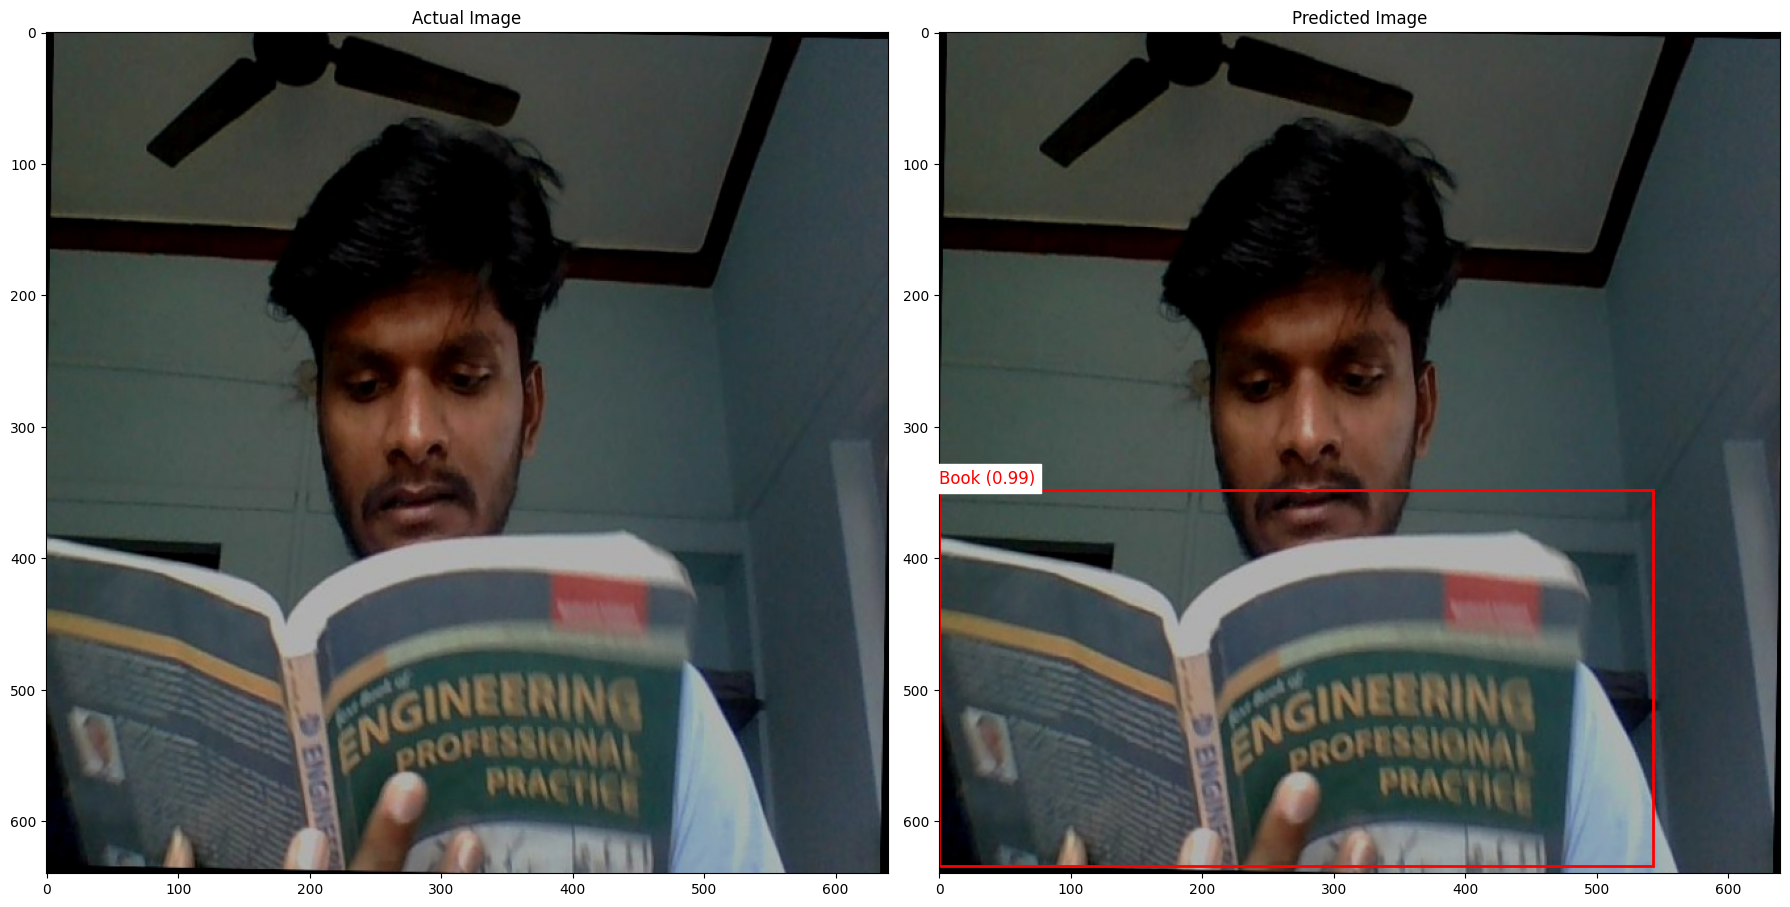

In [ ]:

#for prediction om singl image
import torch
import torchvision.models.detection as detection
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms

#  **Load the Model**
save_path = "/content/drive/MyDrive/dataset/models"
model_filename = "epoch5.pth"  # Replace with your specific file name

# Define the model architecture again
num_classes = 3  # Same number of classes as during training

# Initialize the model architecture
model = detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Modify the classifier head to match your dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Load the trained model weights
checkpoint_path = os.path.join(save_path, model_filename)
model.load_state_dict(torch.load(checkpoint_path))
print(f"🔹 Model loaded from {checkpoint_path}")

#  **Set Device**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()  # Set model to evaluation mode

#  **Image Preprocessing**
def preprocess_image(image_path):
    """
    Function to preprocess the image for prediction.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Define the transformation to normalize the image
    transform = transforms.Compose([transforms.ToTensor()])

    # Apply transformations to the image
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image_tensor, image

#  **Predict on a Single Image**
def predict_on_image(model, image_tensor):
    """
    Function to perform prediction on a single image.
    """
    with torch.no_grad():  # Disable gradient computation during inference
        predictions = model(image_tensor)

    return predictions[0]  # We only need the first image in the batch

#  **Class Mapping**: Map label IDs to class names
class_mapping = {1: 'Book', 2: 'Smart Phone'}

#  **Plot Predictions**
def plot_predictions(image, prediction, threshold=0.5):
    """
    Function to plot predictions on a single image with label names.
    """
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    # Filter boxes by score threshold
    valid_idx = scores > threshold
    boxes = boxes[valid_idx]
    labels = labels[valid_idx]
    scores = scores[valid_idx]

    # Create a figure and axis for the predicted image
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 12))

    # Original image
    ax1.imshow(image)
    ax1.set_title("Actual Image")

    # Predicted image with bounding boxes
    ax2.imshow(image)
    for box, label, score in zip(boxes, labels, scores):
        # Get the class name from the mapping
        class_name = class_mapping.get(label, f"Unknown ({label})")

        rect = patches.Rectangle(
            (box[0], box[1]), box[2] - box[0], box[3] - box[1],
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax2.add_patch(rect)
        ax2.text(
            box[0], box[1] - 5, f'{class_name} ({score:.2f})',
            color='red', fontsize=12, backgroundcolor='white'
        )
    ax2.set_title("Predicted Image")

    # Show the plot
    plt.tight_layout()
    plt.show()

#  **Load a Single Image**
image_path = "/content/drive/MyDrive/dataset/test/images/frame_254_jpg_aug_2.jpg"  # Replace with your image path
image_tensor, image = preprocess_image(image_path)

#  **Make Prediction on the Image**
prediction = predict_on_image(model, image_tensor)

#  **Visualize the Predictions (Actual vs Predicted)**
plot_predictions(image, prediction)
